*Notebook for now because it's easier to debug, should be a python file*

In [1]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
import threading
from skimage import color
from skimage import io
import math
import skimage.filters as filters
from skimage.transform import resize
from skimage import img_as_bool
import traceback

In [76]:
class Vision:
  def __init__(self):
    self.capture = cv2.VideoCapture(1) # capture the camera
    self.window_width = 640
    self.window_height = 480
    self.robot_pos = (0,0)
    self.objective_pos = (0,0)
    self.map_size = 50 #width of the map
    self.robot_angle = 0 #radians  
    self.current_img = None
    self.obstacle_img = None #copy of the current img, void of any drawings used for obst detection
    self.map = None # tbd
    self.img_ratio = self.window_width/self.window_height #depends on camera view


  def setMapSize(self,size):
    """
    set the desired size of the map
    :param size: desired widh of the map
    """
    self.map_size = size
  
  def openWindow(self):
    """
    Open an independant window of the webcam
    """
    while True:
      success, self.current_img = self.capture.read()
      self.obstacle_img = self.current_img.copy()
      self.updateRobot() #update robot pos and angles
      cv2.imshow("Webcam", self.current_img) # This will open an independent window
      if cv2.waitKey(1) & 0xFF==ord('q'): # quit when 'q' is pressed
        self.capture.release()
        break
      if cv2.waitKey(1) & 0xFF==ord('s'): #save image for testing
        cv2.imwrite('capture_.png', self.current_img)

    cv2.destroyAllWindows() 
    cv2.waitKey(1)

  def getRobotPos(self):
    return self.robot_pos
  
  def getObjectivePos(self):
    return self.objective_pos

  def getRobotAngle(self):
    return self.robot_angle

  def getMap(self): #binary map
    return self.map

  def createMap(self):
    """
    Create the binary map and save it
    """
    if self.obstacle_img is None: return
    gray = cv2.cvtColor(self.obstacle_img,cv2.COLOR_BGR2GRAY)
    #smooth = cv2.GaussianBlur(gray, (5,5), 0) #smooth image
    _ , obst_mask = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY_INV)[1] # threshold 20 for black
    closing = cv2.morphologyEx(obst_mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8), iterations=15) #close gaps, 15 iterations
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN,  np.ones((5,5), np.uint8), iterations=7) #clear residuals
    h, w = gray.shape[:2]
    self.img_ratio = w/h
    binary_map = img_as_bool(resize(opening/opening.max(), (int(self.map_size/self.img_ratio),self.map_size)))
    self.map = binary_map.astype(int)
    
  def updateRobot(self):
    """
    Update the position and orientation of the thymio
    """
    if self.current_img is None: return
    gray = cv2.cvtColor(self.current_img, cv2.COLOR_BGR2GRAY)
    _, thymio_mask = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    #closing = cv2.morphologyEx(thymio_mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8), iterations=7) #might not be needed
    opening = cv2.morphologyEx(thymio_mask, cv2.MORPH_OPEN, np.ones((5,5), np.uint8), iterations=7) #7 seems enough
    contours= cv2.findContours(opening,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]
    if len(contours)==1: 
      cv2.drawContours(self.current_img, contours, -1, (0,255,0), 3)
      M = cv2.moments(contours[0]) #maybe add a verificaion if needed
      cx = int(M["m10"] / M["m00"])
      cy = int(M["m01"] / M["m00"])
      cv2.circle(self.current_img, (cx, cy), 6, (0, 0, 255), -1)
      h, w = gray.shape[:2]
      self.img_ratio = w/h
      hm, wm = (int(self.map_size/self.img_ratio),self.map_size) #map height and width
      self.robot_pos = (int(cx/w*wm),int(cy/h*hm))
      self.robot_angle = self.rectifyAngle(cv2.minAreaRect(contours[0]))
      print("robot angle:",self.robot_angle) # for testing
    else: print("i don't see the robot !")

  def rectifyAngle(self,rect):
    """
    Recctify the angle obtained in the range [0,pi]
    """
    if abs(rect[2]) == 0 : return rect[2] #angle
    (width, height) = rect[1]
    if width<height: return ((-rect[2]+180)*np.pi/180)# *np.pi/180
    else: return ((-rect[2]+90)*np.pi/180)

  def findObjectivePos(self):
    """
    update the position of the objective in the map
    """
    if self.map is None:
      print("No map yet")
      return
    gray = cv2.cvtColor(self.obstacle_img, cv2.COLOR_BGR2GRAY)
    hist = cv2.equalizeHist(gray)
    blur = cv2.GaussianBlur(hist, (5,5), cv2.BORDER_DEFAULT)
    circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1, minDist=100, param1=150, param2=35, 
                                minRadius=20, maxRadius=100)
    if circles is not None: circles = np.round(circles[0, :]).astype("int")
    if len(circles) == 1: #found the objective only
      cx,cy,_ = circles[0]
      h, w = gray.shape[:2]
      self.img_ratio = w/h
      hm, wm = (int(self.map_size/self.img_ratio),self.map_size) #map height and width
      self.objective_pos = (int(cx/w*wm),int(cy/h*hm))



In [77]:
vision = Vision()
try: # catch any error to avoid the code crashing
    vision.openWindow()
except Exception:
    traceback.print_exc()
    cv2.destroyAllWindows() 
    cv2.waitKey(1)

i don't see the robot !!
i don't see the robot !!
i don't see the robot !!
i don't see the robot !!
i don't see the robot !!
robot angle: 0.0
robot angle: 0.0
robot angle: 0.0
robot angle: 0.0
robot angle: 0.0
i don't see the robot !!
i don't see the robot !!
i don't see the robot !!
i don't see the robot !!
i don't see the robot !!
i don't see the robot !!
i don't see the robot !!
i don't see the robot !!
i don't see the robot !!
i don't see the robot !!
i don't see the robot !!
i don't see the robot !!
i don't see the robot !!
i don't see the robot !!
i don't see the robot !!
robot angle: 2.9737319946289062
i don't see the robot !!
i don't see the robot !!
robot angle: 3.5763320922851562
robot angle: 4.23638916015625
robot angle: 4.23638916015625
robot angle: 5.355827331542969
robot angle: 5.355827331542969
robot angle: 6.009010314941406
robot angle: 6.115501403808594
robot angle: 6.170173645019531
robot angle: 6.170173645019531
robot angle: 6.5056304931640625
robot angle: 6.56630706

(480, 640, 3)


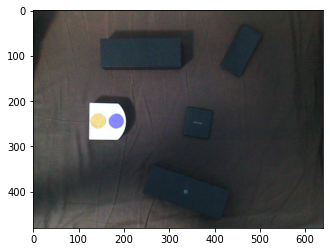

In [72]:
img = cv2.imread('capture.png', cv2.IMREAD_COLOR)
print(img.shape)
plt.imshow(img)

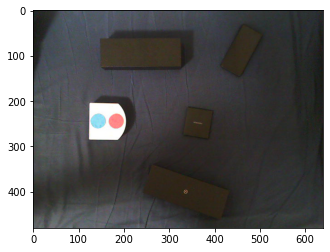

In [73]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

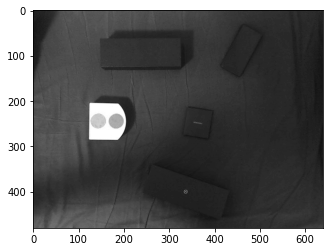

In [74]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray')

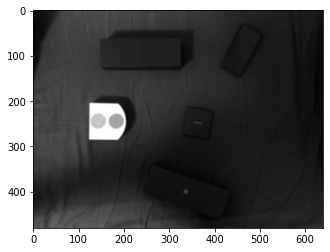

In [75]:
blur = cv2.GaussianBlur(img_gray,(5,5),0) #just try with 5x5, won't probably use though
plt.imshow(blur, cmap='gray')

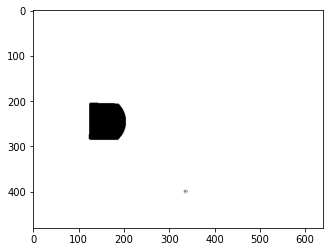

In [76]:
ret ,mask = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY)
plt.imshow(mask, cmap='binary')

In [77]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

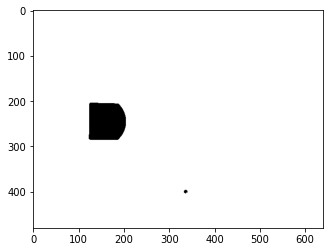

In [78]:
kernal = np.ones((5,5), np.uint8)
closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernal, iterations=7)
plt.imshow(closing,cmap='binary')

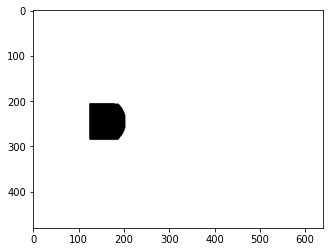

In [79]:
kernal = np.ones((5,5), np.uint8)
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernal, iterations=7)
plt.imshow(opening,cmap='binary')

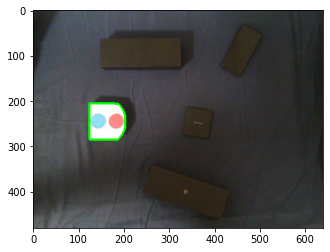

In [80]:
contours,hierarchy = cv2.findContours(opening,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
contours_img = img_rgb.copy()
cv2.drawContours(contours_img, contours, -1, (0,255,0), 3)
plt.imshow(contours_img) #sounds good

(161, 245) 103.16246032714844
(155.13746643066406, 245.21058654785156) -0.0


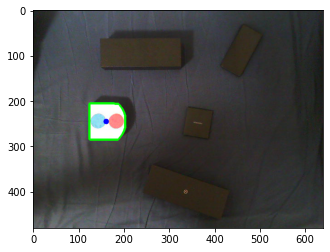

In [81]:
M = cv2.moments(contours[0])
cx = int(M["m10"] / M["m00"])
cy = int(M["m01"] / M["m00"])
(x,y),(MA,ma),angle = cv2.fitEllipse(contours[0])
angle_2 = cv2.minAreaRect(contours[0])[2]
final = cv2.circle(contours_img.copy(), (cx, cy), 6, (0, 0, 255), -1)
plt.imshow(final)
print((cx,cy),angle)
print((x,y),angle_2)


In [106]:
cx, cy

(161, 245)

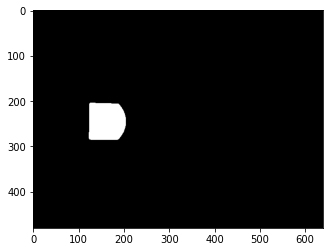

In [82]:
otsu_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
plt.imshow(otsu_mask, cmap='gray')

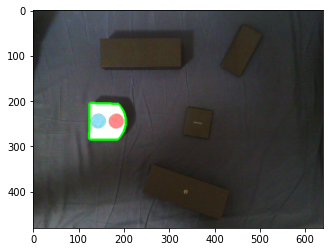

In [83]:
contours2 = cv2.findContours(otsu_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]
contours_img2 = img_rgb.copy()
cv2.drawContours(contours_img2, contours2, -1, (0,255,0), 3)
plt.imshow(contours_img2) 

(161, 245)


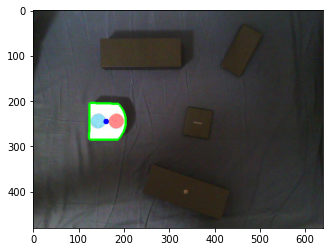

In [84]:
M2 = cv2.moments(contours2[0])
cx2 = int(M["m10"] / M["m00"])
cy2 = int(M["m01"] / M["m00"])
final2 = cv2.circle(contours_img2.copy(), (cx, cy), 6, (0, 0, 255), -1)
plt.imshow(final2)
print((cx2,cy2))

*ok, seems to work without the circles*, test the obstacles...

(480, 640, 3)


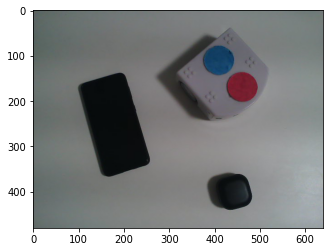

In [85]:
img2 = cv2.imread('capture1.png', cv2.IMREAD_COLOR)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
print(img_rgb.shape)
plt.imshow(img2_rgb)

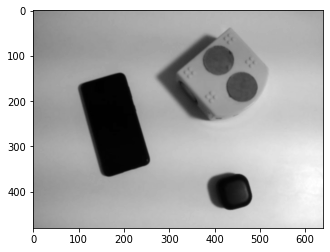

In [86]:
# convert to gray
gray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
# blur
smooth2 = cv2.GaussianBlur(gray2, (5,5), 0)
plt.imshow(smooth2,cmap='gray')

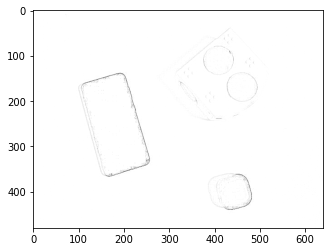

In [87]:
division2 = cv2.divide(gray2, smooth2, scale=255)
plt.imshow(division2,'gray')

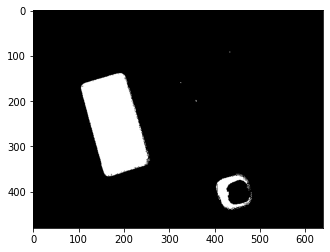

In [88]:
obst_mask = cv2.threshold(gray2, 20, 255, cv2.THRESH_BINARY_INV)[1]
plt.imshow(obst_mask,'gray')

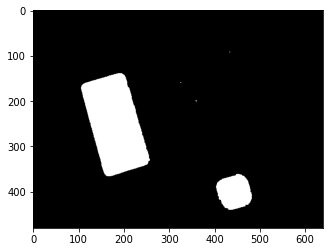

In [89]:
kernal = np.ones((5,5), np.uint8)
closing2 = cv2.morphologyEx(obst_mask, cv2.MORPH_CLOSE, kernal, iterations=15)
plt.imshow(closing2,'gray')

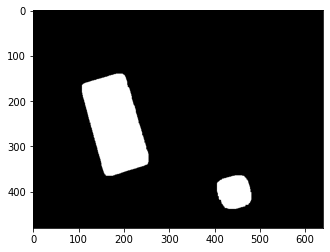

In [90]:
kernal = np.ones((3,3), np.uint8)
opening2 = cv2.morphologyEx(closing2, cv2.MORPH_OPEN, kernal, iterations=7)
plt.imshow(opening2,'gray')

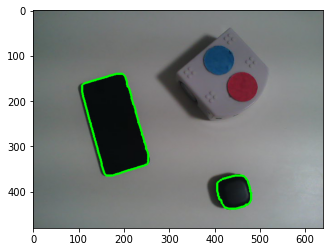

In [91]:
contours_obst = cv2.findContours(opening2,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]
contours_obst_img = img2_rgb.copy()
cv2.drawContours(contours_obst_img, contours_obst, -1, (0,255,0), 3)
plt.imshow(contours_obst_img) 

In [92]:
angle_obst_1 = cv2.minAreaRect(contours_obst[0])[2]
print(angle_obst_1)

74.74488067626953


16.172157287597656


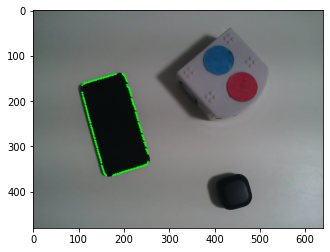

In [93]:
(x, y), (width, height), angle_obst_2 = cv2.minAreaRect(contours_obst[1])
contours_obst1_img = img2_rgb.copy()
cv2.drawContours(contours_obst1_img, contours_obst[1], -1, (0,255,0), 3)
plt.imshow(contours_obst1_img)
if width<height:
    print("rectified",-angle_obst_2+180)
print(-angle_obst_2+90)

In [94]:
litsto= list(cv2.minAreaRect(contours_obst[1]))
litsto[0]

(180.14500427246094, 251.637939453125)

In [95]:
cv2.minAreaRect(contours_obst[1])[1][0]

213.52259826660156

Creating the map

In [96]:
h, w = img2_rgb.shape[:2]
aspect = w/h
print(h,w,aspect)


480 640 1.3333333333333333


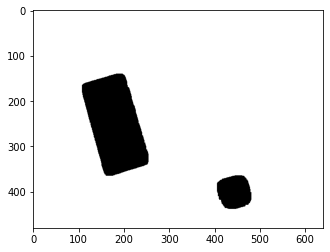

In [97]:
binary_original = opening2/opening2.max()
plt.imshow(binary_original,"binary") 

In [98]:
binary_original

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

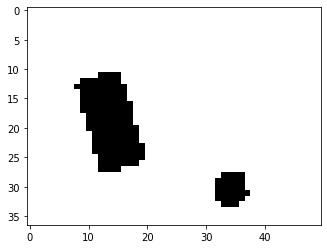

In [99]:
binary_map = img_as_bool(resize(binary_original, (int(50/aspect),50))) #let's say size 50
#cv2.resize(binary_original, (50,int(50/aspect)), interpolation = cv2.INTER_NEAREST)
plt.imshow(binary_map,"binary")

In [100]:
print(binary_map.astype(int))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [107]:
print((cx,cy),angle_2)
print(img_rgb.shape[:2])
print(binary_map.shape[:2])
h, w = img_rgb.shape[:2]
hb, wb = binary_map.shape[:2]
print((int(cx/w*wb),int(cy/h*hb)))

(161, 245) -0.0
(480, 640)
(37, 50)
(12, 18)


In [102]:
img_circles = cv2.imread('capture1.png', cv2.IMREAD_COLOR)

In [103]:
gray_circle = cv2.cvtColor(img_circles, cv2.COLOR_BGR2GRAY)
hist_circle = cv2.equalizeHist(gray_circle)
blur_circle = cv2.GaussianBlur(hist_circle, (5,5), cv2.BORDER_DEFAULT)
circles = cv2.HoughCircles(blur_circle, cv2.HOUGH_GRADIENT, dp= 1, minDist=100, param1=150, param2=35, 
                            minRadius=5, maxRadius=1000)
if circles is not None: circles = np.round(circles[0, :]).astype("int")

In [110]:
x,y,r = circles[0]
print(x,y,r, len(circles))

460 170 34 1


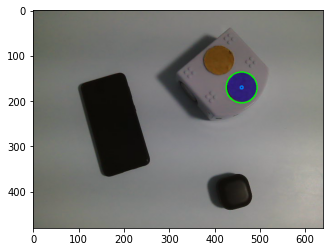

In [105]:
circle_copy = img_circles.copy()
for (x, y, r) in circles:
    cv2.circle(circle_copy, (x, y), r, (0, 255, 0), 2)
    cv2.circle(circle_copy, (x, y), 3, (0, 128, 255), 2)
plt.imshow(circle_copy)

In [108]:
cx,cy,_ = circles[0]
h, w = gray_circle.shape[:2]
img_ratio = w/h
hm, wm = binary_map.shape[:2] #map height and width
objective_pos = (int(cx/w*wm),int(cy/h*hm))

In [109]:
objective_pos

(35, 13)